In [74]:
# openpyxl is needed for Excel files
!pip install openpyxl

# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from google.colab import files

In [75]:
# Dataset Import
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/00352/Online%20Retail.xlsx"
df = pd.read_excel(url)

df = df.copy()

# ==========
# DATA CLEANING
# ==========

# Check for missing values
print("Missing Values:\n", df.isnull().sum())

# Drop rows with missing CustomerID (critical for segmentation)
df = df.dropna(subset=['CustomerID'])

# Drop rows with missing Description (needed for product analysis)
df = df.dropna(subset=['Description'])

# Remove duplicate rows
df = df.drop_duplicates()

# Remove canceled transactions and invalid prices
df = df[(df['Quantity'] > 0) & (df['UnitPrice'] > 0)].copy()

# ---- Outlier Removal: Quantity ----
Q1_qty = df['Quantity'].quantile(0.25)
Q3_qty = df['Quantity'].quantile(0.75)
IQR_qty = Q3_qty - Q1_qty
lower_qty = Q1_qty - 1.5 * IQR_qty
upper_qty = Q3_qty + 1.5 * IQR_qty
df = df[(df['Quantity'] >= lower_qty) & (df['Quantity'] <= upper_qty)]

# ---- Optional: Outlier Removal: UnitPrice ----
Q1_price = df['UnitPrice'].quantile(0.25)
Q3_price = df['UnitPrice'].quantile(0.75)
IQR_price = Q3_price - Q1_price
lower_price = Q1_price - 1.5 * IQR_price
upper_price = Q3_price + 1.5 * IQR_price
df = df[(df['UnitPrice'] >= lower_price) & (df['UnitPrice'] <= upper_price)]

# ---- Data Type Conversions ----
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])
df['CustomerID'] = df['CustomerID'].astype(int).astype(str)
df['StockCode'] = df['StockCode'].astype(str)
df['InvoiceNo'] = df['InvoiceNo'].astype(str)
df['Quantity'] = df['Quantity'].astype(int)
df['Country'] = df['Country'].astype('category')

# ---- Weekend Flag ----
df['Weekday'] = df['InvoiceDate'].dt.dayofweek  # Monday = 0, Sunday = 6
df['IsWeekend'] = df['Weekday'].apply(lambda x: 1 if x >= 5 else 0)


Missing Values:
 InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
Country             0
dtype: int64


In [76]:
# ================
# DATA TRANSFORMATION
# ================

# Calculation of TotalPrice
df['TotalPrice'] = df['Quantity'] * df['UnitPrice']

# time-based features
df['InvoiceDay'] = df['InvoiceDate'].dt.day
df['InvoiceMonth'] = df['InvoiceDate'].dt.month
df['InvoiceYear'] = df['InvoiceDate'].dt.year
df['DayOfWeek'] = df['InvoiceDate'].dt.day_name()
df['InvoiceHour'] = df['InvoiceDate'].dt.hour
df['Weekday'] = df['InvoiceDate'].dt.dayofweek  # (0=Monday)
df['MonthYear'] = df['InvoiceDate'].dt.to_period('M')

# Conversion of DayOfWeek to ordered categorical
days_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
df['DayOfWeek'] = pd.Categorical(df['DayOfWeek'], categories=days_order, ordered=True)
df = df.drop(columns=['Weekday'])


=== Key Statistics ===
        Quantity  UnitPrice TotalPrice
count  333234.00  333234.00  333234.00
mean        7.55       2.19      12.90
std         6.78       1.55      13.21
min         1.00       0.00       0.00
25%         2.00       1.25       3.90
50%         6.00       1.65      10.14
75%        12.00       2.95      17.40
max        27.00       7.50     178.80

=== Feature Correlations ===
           Quantity UnitPrice TotalPrice
Quantity      1.000    -0.350      0.513
UnitPrice    -0.350     1.000      0.358
TotalPrice    0.513     0.358      1.000


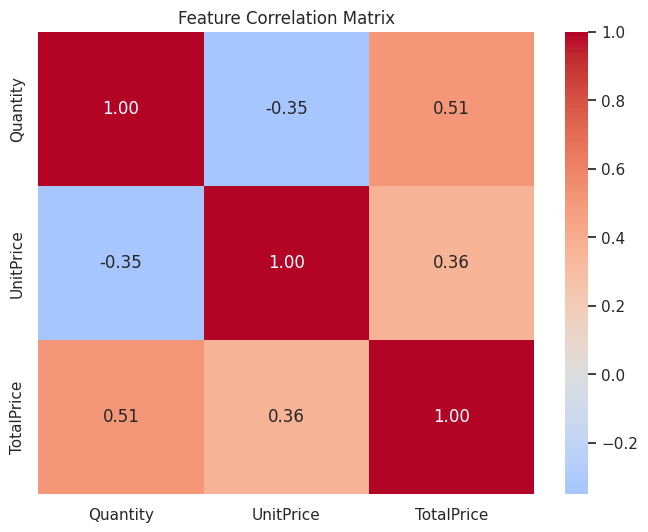


=== Spending Patterns ===


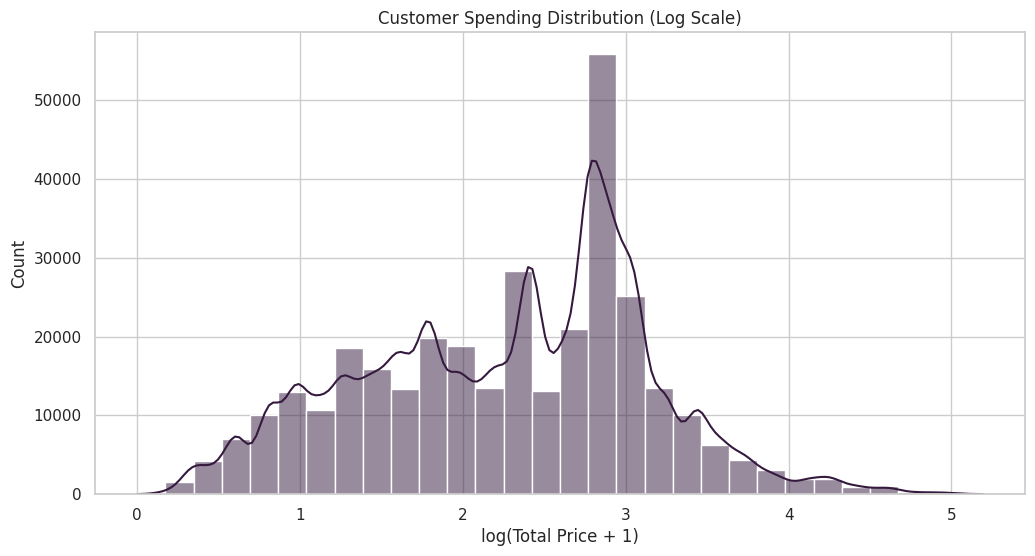

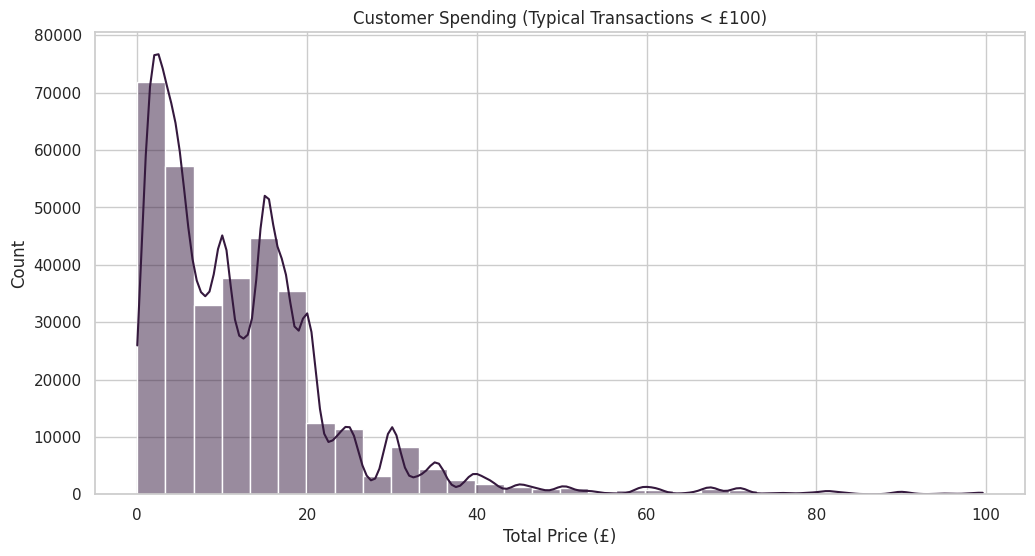


=== Sales Trends ===


<ipython-input-77-f80115676c91>:44: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_sales = df.groupby(pd.Grouper(key='InvoiceDate', freq='M'))['TotalPrice'].sum()


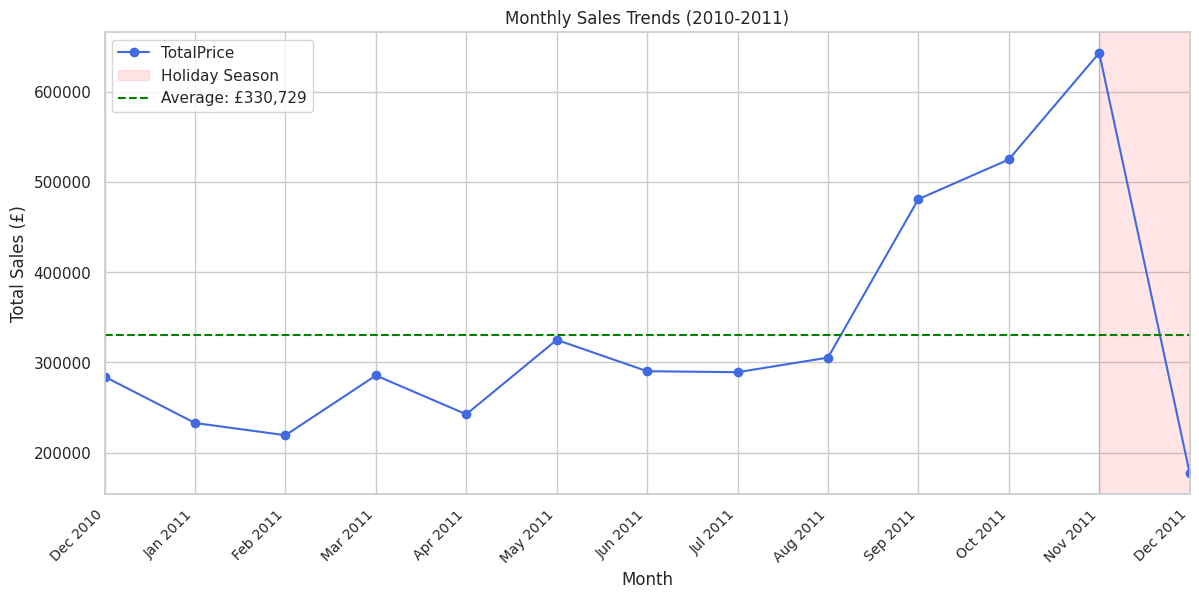

<ipython-input-77-f80115676c91>:67: FutureWarning: 'Q' is deprecated and will be removed in a future version, please use 'QE' instead.
  quarterly_sales = df.groupby(pd.Grouper(key='InvoiceDate', freq='Q'))['TotalPrice'].sum()



Quarterly Sales:
InvoiceDate
2010-12-31      £284,122
2011-03-31      £737,419
2011-06-30      £857,479
2011-09-30    £1,075,202
2011-12-31    £1,345,254
Freq: QE-DEC, Name: TotalPrice, dtype: object

=== Customer Geography ===


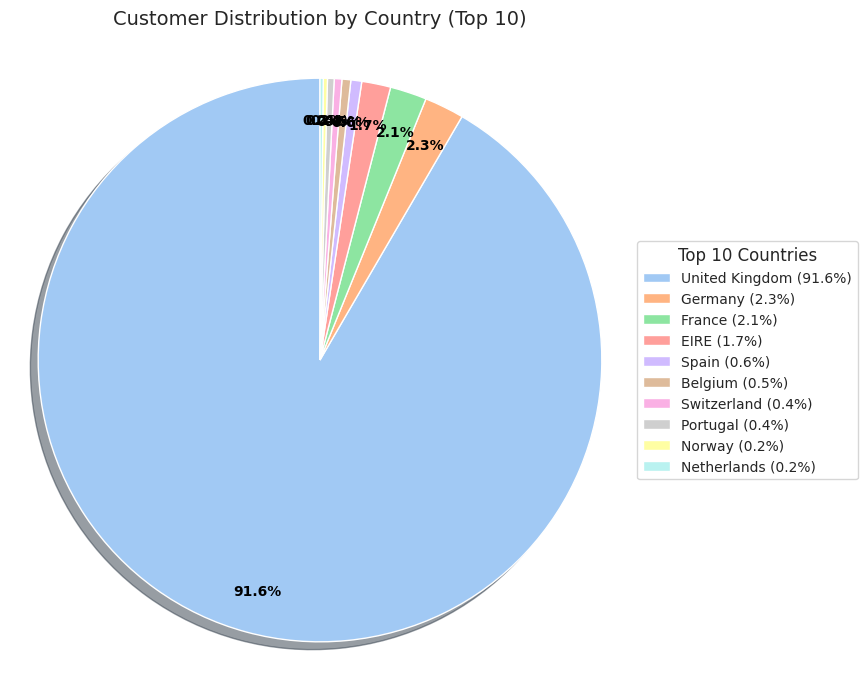


Top 10 Countries by Customer Count:
Country
United Kingdom    300281
Germany             7448
France              6890
EIRE                5443
Spain               2040
Belgium             1660
Switzerland         1433
Portugal            1252
Norway               772
Netherlands          617
Name: count, dtype: int64

=== Product Frequency ===


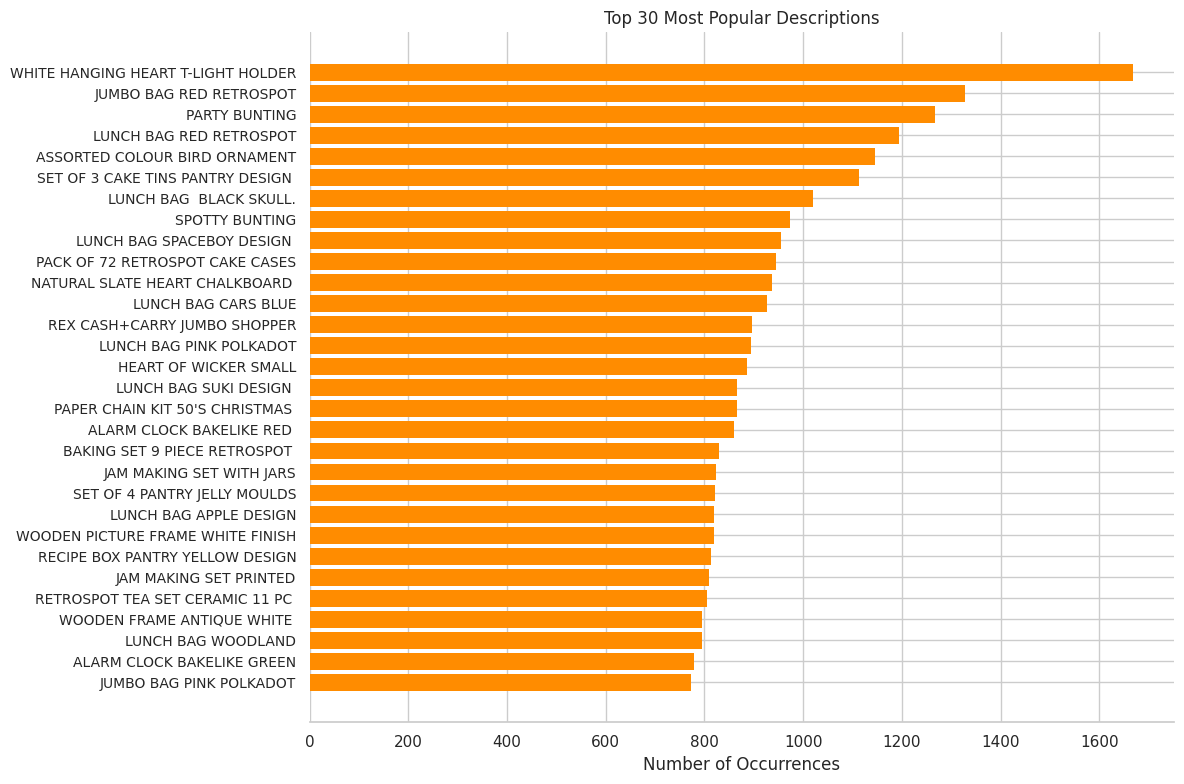

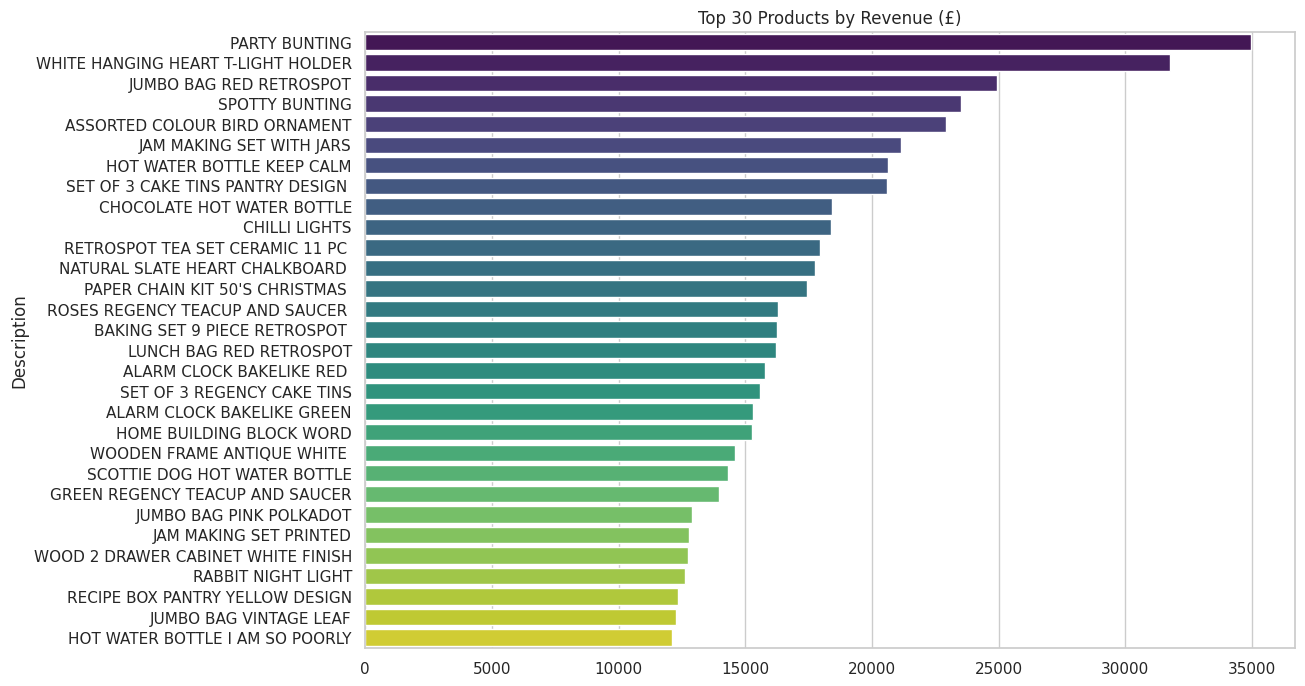

In [77]:
# ======================
# EXPLORATORY DATA ANALYSIS (EDA)
# ======================

# Set visual style
sns.set_theme(style="whitegrid", palette="rocket")

# ----- 1. Summary Statistics -----
print("\n=== Key Statistics ===")
print(df[['Quantity', 'UnitPrice', 'TotalPrice']].describe().map(lambda x: f"{x:.2f}"))

# ----- 2. Correlation Analysis -----
print("\n=== Feature Correlations ===")
corr_matrix = df[['Quantity', 'UnitPrice', 'TotalPrice']].corr()
print(corr_matrix.map(lambda x: f"{x:.3f}"))

plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", center=0)
plt.title('Feature Correlation Matrix')
plt.savefig('correlation_matrix.png')
plt.show()

# ----- 3. Spending Distribution -----
print("\n=== Spending Patterns ===")
plt.figure(figsize=(12, 6))
sns.histplot(np.log1p(df['TotalPrice']), bins=30, kde=True)
plt.title('Customer Spending Distribution (Log Scale)')
plt.xlabel('log(Total Price + 1)')
plt.ylabel('Count')
plt.show()

# Filter for typical transactions
typical_spending = df[df['TotalPrice'] < 100]
plt.figure(figsize=(12, 6))
sns.histplot(typical_spending['TotalPrice'], bins=30, kde=True)
plt.title('Customer Spending (Typical Transactions < £100)')
plt.xlabel('Total Price (£)')
plt.ylabel('Count')
plt.show()

# ----- 4. Time Trends -----
print("\n=== Sales Trends ===")
# Monthly trends (fixed frequency from 'ME' to 'M')
monthly_sales = df.groupby(pd.Grouper(key='InvoiceDate', freq='M'))['TotalPrice'].sum()
plt.figure(figsize=(14, 6))
monthly_sales.plot(marker='o', linestyle='-', color='royalblue')

# Highlight holiday season
plt.axvspan(pd.Timestamp('2011-11-01'), pd.Timestamp('2011-12-31'),
            color='red', alpha=0.1, label='Holiday Season')
plt.axhline(monthly_sales.mean(), color='green', linestyle='--',
            label=f'Average: £{monthly_sales.mean():,.0f}')

plt.title('Monthly Sales Trends (2010-2011)')
plt.xlabel('Month')
plt.ylabel('Total Sales (£)')

# Convert index to datetime and format
monthly_sales.index = pd.to_datetime(monthly_sales.index)
plt.xticks(monthly_sales.index, monthly_sales.index.strftime('%b %Y'), rotation=45, fontsize=10, ha='right')
plt.legend()
plt.grid(True)
plt.savefig('monthly_sales_trends.png')
plt.show()

# Quarterly summary (no change needed)
quarterly_sales = df.groupby(pd.Grouper(key='InvoiceDate', freq='Q'))['TotalPrice'].sum()
print("\nQuarterly Sales:")
print(quarterly_sales.apply(lambda x: f"£{x:,.0f}"))

# ----- 5. Customer Demographics -----
print("\n=== Customer Geography ===")
top_countries = df['Country'].value_counts().head(10)

plt.figure(figsize=(8, 8))
colors = sns.color_palette('pastel')[0:10]
patches, texts, autotexts = plt.pie(
    top_countries,
    labels=None,
    colors=colors,
    autopct='%1.1f%%',
    pctdistance=0.85,
    startangle=90,
    shadow=True,
    textprops={'fontsize': 10, 'color': 'black', 'weight': 'bold'}
)

legend_labels = [f"{country} ({pct.get_text()})"
                 for country, pct in zip(top_countries.index, autotexts)]
plt.legend(
    patches,
    legend_labels,
    title="Top 10 Countries",
    loc="center left",
    bbox_to_anchor=(1, 0.5),
    fontsize=10
)
plt.axis('equal')
plt.title('Customer Distribution by Country (Top 10)', pad=20, fontsize=14)
plt.savefig('customer_demographics.png')
plt.show()

# Verify top countries match the image
print("\nTop 10 Countries by Customer Count:")
print(top_countries)

# ----- 6. Product Analysis (Frequency of Descriptions) -----
print("\n=== Product Frequency ===")
df['Description'] = df['Description'].str.upper()

# 1. Compute counts of each Description, take top N
top_n = 30
desc_counts = df['Description'].value_counts().head(top_n)

# 2. Set a light grid theme
sns.set_theme(style="whitegrid")

# 3. Plot horizontal bar chart
plt.figure(figsize=(12, 8))
bars = plt.barh(
    y=desc_counts.index[::-1],
    width=desc_counts.values[::-1],
    color='darkorange',
    edgecolor='none'
)

plt.title(f"Top {top_n} Most Popular Descriptions")
plt.xlabel("Number of Occurrences")
plt.ylabel("")
plt.tick_params(axis='y', labelsize=10)

# 4. Clean up spines
for spine in ['top','right','left']:
    plt.gca().spines[spine].set_visible(False)

plt.tight_layout()
plt.savefig('product_frequency.png')
plt.show()


top_products_revenue = df.groupby('Description')['TotalPrice'].sum().sort_values(ascending=False).head(30)
plt.figure(figsize=(12, 8))
sns.barplot(
    x=top_products_revenue.values,
    y=top_products_revenue.index,
    hue=top_products_revenue.index,
    palette='viridis',
    legend=False
)
plt.title('Top 30 Products by Revenue (£)')
plt.savefig('top_products_revenue.png')
plt.show()


=== Customer Segmentation Analysis ===


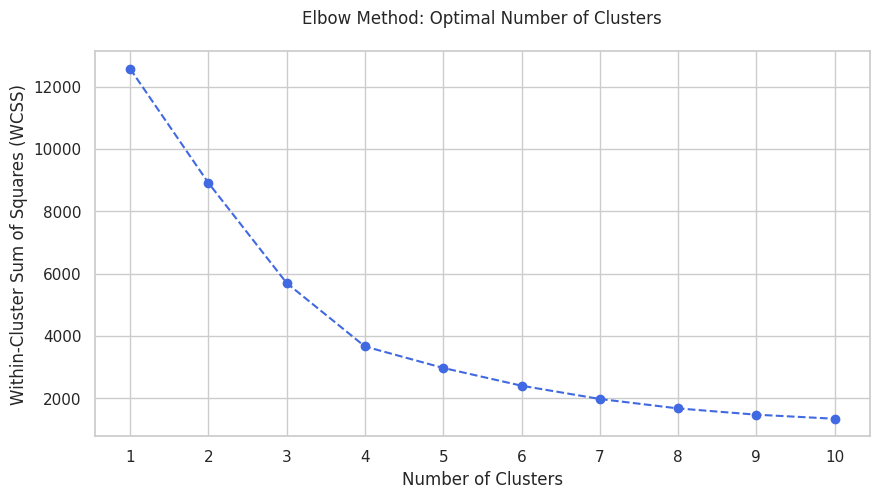

In [78]:
# ======================
# CUSTOMER SEGMENTATION (RFM + Clustering)
# ======================
print("\n=== Customer Segmentation Analysis ===")

# --- RFM Calculation ---
snapshot_date = df['InvoiceDate'].max() + pd.DateOffset(days=1)
rfm = df.groupby('CustomerID').agg({
    'InvoiceDate': lambda x: (snapshot_date - x.max()).days,  # Recency
    'InvoiceNo': 'nunique',                                  # Frequency
    'TotalPrice': 'sum'                                      # Monetary
}).reset_index()
rfm.columns = ['CustomerID', 'Recency', 'Frequency', 'Monetary']

# --- Data Normalization ---
scaler = StandardScaler()
rfm_scaled = scaler.fit_transform(rfm[['Recency', 'Frequency', 'Monetary']])

# --- Elbow Method for Optimal Clusters ---
wcss = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, random_state=42, n_init=10)
    kmeans.fit(rfm_scaled)
    wcss.append(kmeans.inertia_)

plt.figure(figsize=(10, 5))
plt.plot(range(1, 11), wcss, marker='o', linestyle='--', color='royalblue')
plt.title('Elbow Method: Optimal Number of Clusters', pad=20)
plt.xlabel('Number of Clusters')
plt.ylabel('Within-Cluster Sum of Squares (WCSS)')
plt.xticks(range(1, 11))
plt.grid(True)
plt.savefig('elbow_method.png')
plt.show()




Core Customers Transactions Summary:
            Quantity      UnitPrice     TotalPrice
count  279202.000000  279202.000000  279202.000000
mean        7.778555       2.179142      13.253808
std         6.789003       1.535207      13.359173
min         1.000000       0.001000       0.001000
25%         2.000000       1.250000       4.200000
50%         6.000000       1.650000      10.200000
75%        12.000000       2.950000      17.400000
max        27.000000       7.500000     178.800000


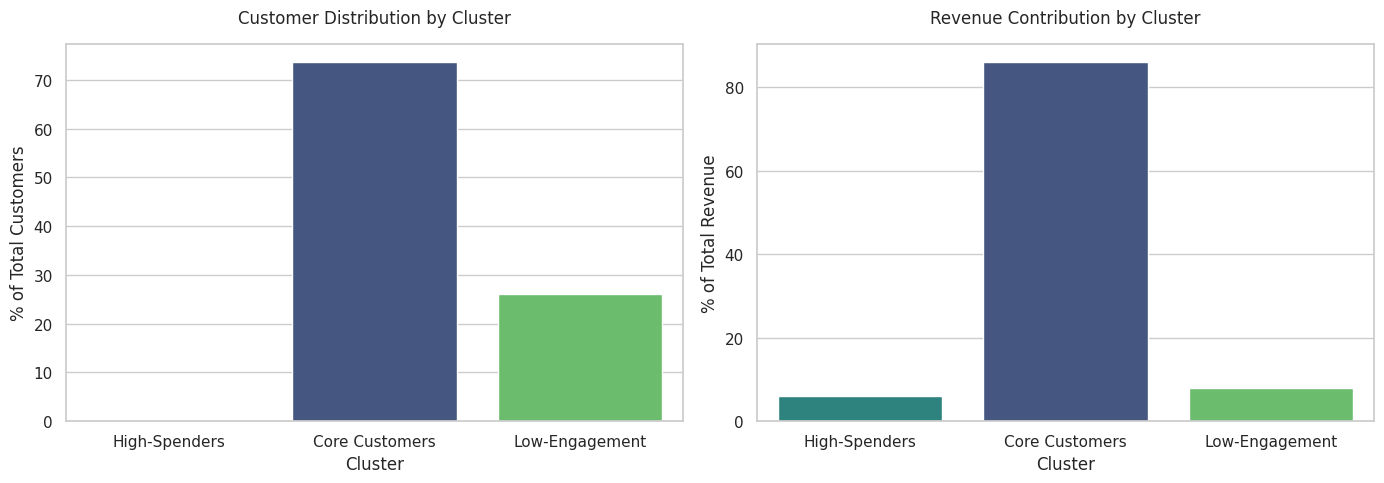


=== RFM Cluster Profiles ===

Business Interpretation:
- High-Spenders: Few customers (0.2%) with very high individual spend (£32,550) but low overall revenue contribution (6.1%).
- Core Customers: Bulk of revenue (86.1%) from 73.7% of customers. Focus retention efforts here.
- Low-Engagement: 26.1% of customers contributing minimal revenue (7.9%). Consider re-engagement campaigns.



,Cluster,Recency_Mean,Frequency_Mean,Monetary_Mean,Customer_Count,%_Customers,%_Revenue
0,Core Customers,39.7 days,4.6,"£1,198",3089,73.7%,86.1%
1,High-Spenders,2.8 days,103.8,"£32,550",8,0.2%,6.1%
2,Low-Engagement,242.2 days,1.6,£309,1094,26.1%,7.9%


In [79]:
# --- K-Means Clustering (k=3) ---
# Despite ambiguity, k=3 is chosen to capture High/Mid/Low tiers
kmeans = KMeans(n_clusters=3, random_state=42, n_init=10)
rfm['Cluster'] = kmeans.fit_predict(rfm_scaled)

# Get cluster centroids and sort by Monetary value
centroids = kmeans.cluster_centers_
cluster_order = centroids[:, 2].argsort()  # Sort by Monetary (3rd column)

# Map labels based on sorted centroids
cluster_labels = {
    cluster_order[0]: 'Low-Engagement',
    cluster_order[1]: 'Core Customers',
    cluster_order[2]: 'High-Spenders'
}
rfm['Cluster'] = rfm['Cluster'].map(cluster_labels)

# Investigate Core Customers cluster
core_customers = rfm[rfm['Cluster'] == 'Core Customers']['CustomerID']
core_transactions = df[df['CustomerID'].isin(core_customers)]

print("\nCore Customers Transactions Summary:")
print(core_transactions[['Quantity', 'UnitPrice', 'TotalPrice']].describe())

# --- Cluster Analysis ---
cluster_stats = rfm.groupby('Cluster').agg(
    Recency_Mean=('Recency', 'mean'),
    Frequency_Mean=('Frequency', 'mean'),
    Monetary_Mean=('Monetary', 'mean'),
    Customer_Count=('CustomerID', 'count')
).reset_index()

# Calculate percentages
cluster_stats['%_Customers'] = (cluster_stats['Customer_Count'] / cluster_stats['Customer_Count'].sum() * 100).round(1)
cluster_stats['%_Revenue'] = (cluster_stats['Monetary_Mean'] * cluster_stats['Customer_Count'] / rfm['Monetary'].sum() * 100).round(1)

# --- Visualizations ---
plt.figure(figsize=(14, 5))

# Plot 1: Customer Distribution
plt.subplot(1, 2, 1)
sns.barplot(
    x='Cluster',
    y='%_Customers',
    hue='Cluster',
    data=cluster_stats,
    palette='viridis',
    legend=False,
    order=['High-Spenders', 'Core Customers', 'Low-Engagement']  # Updated order
)
plt.title('Customer Distribution by Cluster', pad=15)
plt.ylabel('% of Total Customers')

# Plot 2: Revenue Distribution
plt.subplot(1, 2, 2)
sns.barplot(
    x='Cluster',
    y='%_Revenue',
    hue='Cluster',
    data=cluster_stats,
    palette='viridis',
    legend=False,
    order=['High-Spenders', 'Core Customers', 'Low-Engagement']  # Updated order
)
plt.title('Revenue Contribution by Cluster', pad=15)
plt.ylabel('% of Total Revenue')

plt.tight_layout()
plt.show()

# --- Print Cluster Statistics ---
print("\n=== RFM Cluster Profiles ===")
print("""
Business Interpretation:
- High-Spenders: Few customers (0.2%) with very high individual spend (£32,550) but low overall revenue contribution (6.1%).
- Core Customers: Bulk of revenue (86.1%) from 73.7% of customers. Focus retention efforts here.
- Low-Engagement: 26.1% of customers contributing minimal revenue (7.9%). Consider re-engagement campaigns.
""")
display(cluster_stats.style
    .format({
        'Recency_Mean': '{:.1f} days',
        'Frequency_Mean': '{:.1f}',
        'Monetary_Mean': '£{:,.0f}',
        '%_Customers': '{:.1f}%',
        '%_Revenue': '{:.1f}%'
    })
    .background_gradient(cmap='Blues', subset=['%_Revenue'])
    .set_caption('Key Metrics by Customer Cluster')
)


=== Customer Lifetime Value (CLV) Estimation ===


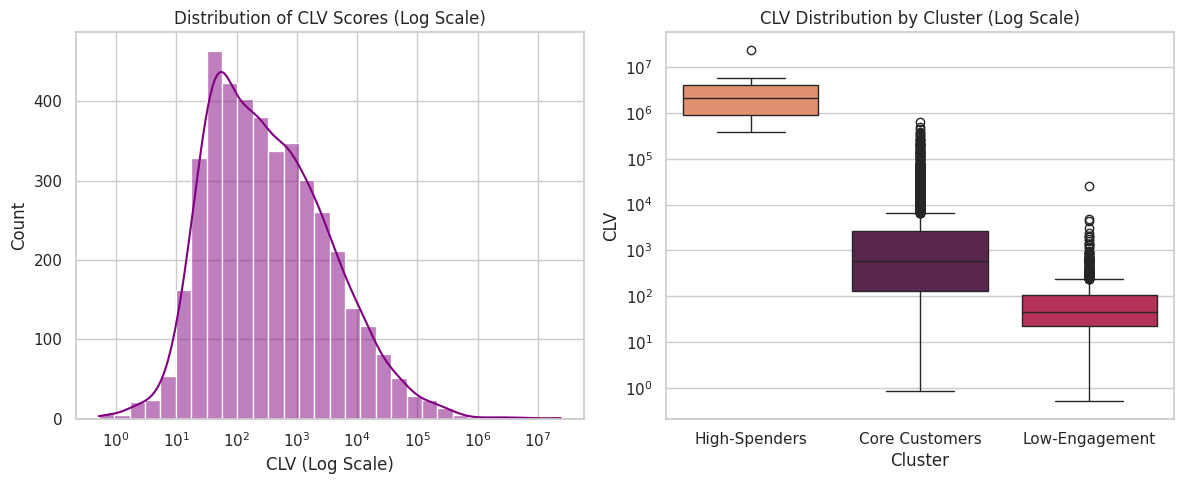


Top 10 Customers by CLV:


,Cluster,Recency,Frequency,Monetary,CLV
1828,High-Spenders,1 days,193,"£84,980.89","£23,662,091.15"
323,High-Spenders,1 days,196,"£20,519.88","£5,802,370.11"
3885,High-Spenders,2 days,123,"£32,224.59","£3,607,846.56"
2113,High-Spenders,1 days,91,"£17,712.96","£2,325,450.36"
542,High-Spenders,4 days,80,"£36,347.88","£1,806,736.61"
1614,High-Spenders,1 days,90,"£8,207.41","£1,065,671.07"
3771,Core Customers,1 days,31,"£14,162.95","£633,417.35"
1641,Core Customers,2 days,46,"£11,901.92","£498,345.34"
1392,High-Spenders,8 days,40,"£24,387.53","£443,969.73"
767,Core Customers,2 days,52,"£9,337.80","£441,980.86"



Duplicate invoices in top CLV customers: 0


In [80]:
# ======================
# CUSTOMER LIFETIME VALUE (CLV)
# ======================
print("\n=== Customer Lifetime Value (CLV) Estimation ===")

# Calculate CLV using revised formula
rfm['CLV'] = (rfm['Frequency'] * rfm['Monetary']) / np.log(rfm['Recency'] + 1)

# Analyze CLV distribution
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
sns.histplot(rfm['CLV'], bins=30, kde=True, color='purple', log_scale=True)
plt.title('Distribution of CLV Scores (Log Scale)')
plt.xlabel('CLV (Log Scale)')
plt.ylabel('Count')

plt.subplot(1, 2, 2)
sns.boxplot(
    x='Cluster',
    y='CLV',
    hue='Cluster',
    data=rfm,
    palette='rocket',
    order=['High-Spenders', 'Core Customers', 'Low-Engagement'],
    legend=False
)
plt.title('CLV Distribution by Cluster (Log Scale)')
plt.yscale('log')
plt.tight_layout()
plt.savefig('clv_distribution.png')
plt.show()

# Validate top customers for duplicates
top_clv = rfm[['Cluster', 'Recency', 'Frequency', 'Monetary', 'CLV']] \
    .sort_values('CLV', ascending=False) \
    .head(10)
print("\nTop 10 Customers by CLV:")
display(top_clv.style.format({
    'Recency': '{:.0f} days',
    'Frequency': '{:.0f}',
    'Monetary': '£{:,.2f}',
    'CLV': '£{:,.2f}'
}))

top_customer_ids = top_clv.index.tolist()
customer_transactions = df[df['CustomerID'].isin(top_customer_ids)]
duplicate_invoices = customer_transactions.duplicated(subset=['CustomerID', 'InvoiceNo']).sum()
print(f"\nDuplicate invoices in top CLV customers: {duplicate_invoices}")

# RESULTS & INSIGHTS

## BUSINESS INSIGHTS SUMMARY

1. **Product Popularity**  
   - **Top 3 Frequent Purchases**:  
     - WHITE HANGING HEART T-LIGHT HOLDER  
     - JUMBO BAG RED RETROSPOT  
     - PARTY BUNTING  
   - **Top 3 Revenue Generators**:  
     - PARTY BUNTING  
     - WHITE HANGING HEART T-LIGHT HOLDER  
     - JUMBO BAG RED RETROSPOT  

2. **Customer Segmentation**  
   - **Core Customers (73.7%)** contribute **86.1% of total revenue** (focus on retention)  
   - **High-Spenders (0.2%)** have extreme CLV (e.g., £23M) but contribute only 6.1% to revenue  
   - **Low-Engagement (26.1%)** need re-engagement strategies (7.9% revenue contribution)  

3. **Sales Trends**  
   - **Peak Sales**: November-December 2011 (holiday season)  
   - **Monthly Average Sales**: £330,729  

4. **Recommendations**  
   - Stock seasonal items (e.g., party supplies)  
   - Launch loyalty programs for Core Customers  
   - Target High-Spenders with exclusive offers  
   - Re-engage Low-Engagement customers with promotions  

**Key Visualizations**:  
- Monthly sales trends show clear holiday season spikes  
- Core Customers dominate revenue despite small High-Spender segment  
- Popular products are consistent across frequency and revenue metrics  